In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense
# sns.set_style("whitegrid")
plt.style.use('seaborn')

Using TensorFlow backend.


In [17]:
# base_dir = 'd:/GitHub/python-2-work/' # work
base_dir = 'd:/SRC/ensemble-forecasting/'  # home
h = np.loadtxt(base_dir + 'data/2011/2011080100_hiromb_GI_60x434.txt') - 37.356
s = np.loadtxt(base_dir + 'data/2011/2011080100_swan_GI_48x434.txt')
n = np.loadtxt(base_dir + 'data/2011/2011080100_noswan_GI_48x434.txt')
m = np.loadtxt(base_dir + 'data/2011/2011080100_measurements_GI_2623.txt')

# forecast dimensions
N = 100 # 430
T = 48

# preparing measurements forecast
m_fc = np.zeros((N, T+1))
for i in range(N):
    for j in range(T+1):
        m_fc[i, j] = m[i*6+j]

# data cut and shifting
shift_const = 0
h = h[0:N, 1:T+1] + shift_const
s = s[0:N, 1:T+1] + shift_const
n = n[0:N, 1:T+1] + shift_const
m_fc = m_fc[0:N, 1:T+1] + shift_const
h.shape, s.shape, n.shape, m_fc.shape

((100, 48), (100, 48), (100, 48), (100, 48))

In [18]:
a = opt.minimize(lambda a: np.mean(np.abs(a[0] + a[1]*h + a[2]*s - m_fc)), 
                 [0, 0.5, 0.5]).x
ens = a[0] + a[1]*h + a[2]*s        
                 
def plot_ensemble(q):
    plt.figure()
    plt.plot(h[q], 'r-')
    plt.plot(s[q], 'g-')
    plt.plot(m_fc[q], 'ko')
    plt.plot(ens[q], 'm-', linewidth=2)
    plt.title('h:{0:.2f} s:{1:.2f} ens:{2:.2f}'.format(np.mean(np.abs(h[q] - m_fc[q])),
              np.mean(np.abs(s[q] - m_fc[q])), 
              np.mean(np.abs(ens[q] - m_fc[q]))))

a

array([ 4.43578599,  0.60883084,  0.28889434])

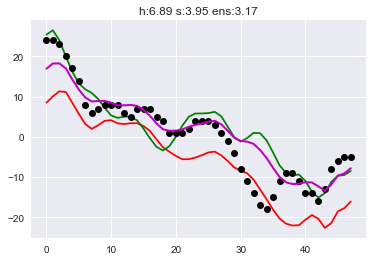

In [19]:
plot_ensemble(50)

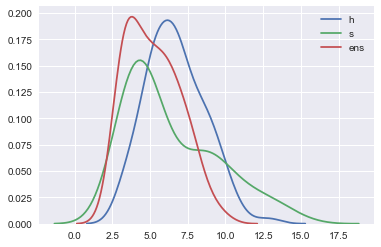

In [20]:
sns.kdeplot(np.mean(np.abs(h - m_fc), axis=1), label='h')
sns.kdeplot(np.mean(np.abs(s - m_fc), axis=1), label='s')
sns.kdeplot(np.mean(np.abs(ens - m_fc), axis=1), label='ens')

In [28]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def baseline_ann_ensemble():
    model = Sequential()
    model.add(Dense(units=2, kernel_initializer='normal', activation='relu', input_dim=2))
    model.add(Dense(units=1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
X = np.vstack((h.flatten(), s.flatten())).transpose()
Y = m_fc.flatten()
seed = 7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=baseline_ann_ensemble, epochs=100, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -52.76 (26.59) MSE


In [30]:
# [model.predict([h[230, tt], s[230,tt]]) for tt in range(T)]
plt.plot(estimator.predict(np.array([h[50], s[50]]).transpose()))

AttributeError: 'KerasRegressor' object has no attribute 'model'